In [7]:
from braingeneers import analysis
import braingeneers.data.datasets_electrophysiology as ephys
import braingeneers.utils.smart_open_braingeneers as smart_open
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from braingeneers.analysis import plot
from braingeneers.analysis import single_unit
import pywt
import spkit as sp
from scipy import signal, ndimage
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize, LogNorm, NoNorm
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import time

fs = 20000.0

In [8]:
def spectrogram_plot(z, times, frequencies, coif, cmap=None, norm=Normalize(), ax=None, colorbar=True):
    ###########################################################################
    # plot
    
    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    xx,yy = np.meshgrid(times,frequencies)
    ZZ = z
    
    im = ax.pcolor(xx,yy,ZZ, norm=norm, cmap=cmap)
    # ax.plot(times,coif)
    # ax.fill_between(times,coif, step="mid", alpha=0.4)
    
    if colorbar:
        cbaxes = inset_axes(ax, width="2%", height="90%", loc=4) 
        fig.colorbar(im, cax=cbaxes, orientation='vertical')

    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(frequencies.min(), frequencies.max())

    return ax

In [9]:
def cwt_spectrogram(x, fs, nNotes=12, detrend=True, normalize=True):
    
    N = len(x)
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
    
#     print (scales)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef, freqs=pywt.cwt(x, scales, 'cmor1-1')
    frequencies = pywt.scale2frequency('cmor1-1', scales) / dt
    
    ###########################################################################
    # power
#     power = np.abs(coef)**2
    power = np.abs(coef * np.conj(coef))
    
    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return power, times, frequencies, coif

In [10]:
N = 1000 * 40
nNotes = 12
dt = 1.0 / 1000.0
nOctaves = int(np.log2(2*np.floor(N/2.0)))
scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
frequencies = pywt.scale2frequency('cmor1-1', scales) / dt
print(min(frequencies), max(frequencies))

##  cmor0.1-0.1 what are good bw and center frequency?

0.032332247752664335 500.0


In [11]:
folder_dir = "/home/kang/disk/Opto/20230510_ucsf/"
rec_hckcr_3_path = folder_dir + "hc52_chip18790_rec51023_1.raw.h5"
rec_hckcr_3_curation_path = folder_dir + "hc52_chip18790_rec51023_1_curated.zip"
file_name = "hc52_chip18790_rec51023_1"

In [12]:
import h5py
f = h5py.File(rec_hckcr_3_path, 'r+')
f['settings']['hpf'][0]


BlockingIOError: [Errno 11] Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [8]:
# folder_dir = "/home/kang/disk/Opto/20230402_ucsf/"
# rec_hckcr_3_path = folder_dir + "2023_04_04_hc328_hckcr1-2_3.raw.h5"
# rec_hckcr_3_curation_path = folder_dir + "2023_04_04_hc328_hckcr1-2_3_phy/2023_04_04_hc328_hckcr1-2_3_curated.zip"
# file_name = "2023_04_04_hc328_hckcr1-2_3.raw.h5"

In [9]:
# folder_dir = "/home/kang/disk/Opto/20221019_ucsf/"
# rec_hckcr_3_path = folder_dir + "hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5"
# rec_hckcr_3_curation_path = folder_dir + "hc9.19_chp-16849_plated-10.19.22_rec10.19.22_curated.zip"
# file_name = "hc9.19_chp-16849_plated-10.19.22_rec10.19.22"

In [10]:
# folder_dir = "/home/kang/disk/Opto/20230402_ucsf/2023_04_02_hc238_spt/"
# rec_hckcr_3_path = folder_dir + "2023_04_02_hc328_5.raw.h5"
# rec_hckcr_3_curation_path = folder_dir + "2023_04_02_hc328_5_curated.zip"

In [11]:
# folder_dir = "/home/kang/disk/Opto/20230402_ucsf/"
# rec_hckcr_3_path = folder_dir + "Trace_20230418_15_10_08_chip16235.raw.h5"
# rec_hckcr_3_curation_path = folder_dir + "Trace_20230418_15_10_08_chip16235_phy.zip"

In [12]:
spike_data_hckcr_3 = analysis.read_phy_files(rec_hckcr_3_curation_path)
stim_pairs_bi = ephys.load_gpio_maxwell(rec_hckcr_3_path)
print(stim_pairs_bi)
print(stim_pairs_bi.shape)

[[ 80.0817   90.08165]
 [ 90.18265 100.1826 ]
 [100.2907  110.29065]
 [110.4119  120.41185]
 [130.4287  140.42865]]
(5, 2)


In [13]:
# Downsample abd remove artifact
def downsample(wav_lfp, dec=20, fs=20000.0):
    wav_data = signal.decimate(wav_lfp, dec)
    return fs/dec, wav_data

def artifact_removal(wav_lfp):
    corrected_lfp = sp.eeg.ATAR(wav_lfp.copy(),winsize=128*8, beta=0.1, 
                      OptMode='elim', IPR=[25,75], k1=1, k2=10, verbose=0)[0, :]
    return corrected_lfp

In [14]:
spike_data_hckcr_3.N

44

In [90]:
# calculate spectrogram
figure_path = "lfp_test/"
fs = 20000.0
dec = 20
fs_down = fs/dec
sections = ["pre", "stim"]
rec_period = [[60, 80], [80, 100]]
for i in range(40, 41):
    channel = [spike_data_hckcr_3.neuron_data[0][i]['channel']]
    raw_trace = {"pre": single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, rec_period[0]),
                "stim": single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, rec_period[1])}
    print(i, channel,
          raw_trace["pre"].shape,
          raw_trace["stim"].shape)
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    for j in range(len(sections)):
        raw_trace_sec = raw_trace[sections[j]]
        wav_lfp = analysis.butter_bandpass_filter(raw_trace_sec, 0.1, 100)
        lfp_cor = artifact_removal(downsample(wav_lfp, dec=dec)[1])
        print(lfp_cor.shape)
        power, times, frequencies, coif = cwt_spectrogram(lfp_cor, fs_down, nNotes=12)
        total_duration = len(lfp_cor) / fs_down
        spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(vmin=10e-8, vmax=10e4), ax=axs[j])
        axs[j].set_title("cluster" + str(i) + sections[j], fontsize=12)
        axs[j].set_xlim(0, total_duration)
        # ax[0].set_ylim(0, 0.5*sampling_frequency)
        # ax[0].set_ylim(1, max(frequencies))
        axs[j].set_ylim(1, 100)
        axs[j].set_xlabel('time (s)')
        axs[j].set_ylabel('frequency (Hz)')
        axs[j].set_yscale('log')
    # plt.show(block=False)
    plt.savefig(figure_path+"cluster"+str(i)+sections[j]+"removal.png", dpi=300)
    plt.close()

40 [962] (1, 400000) (1, 400000)
WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: elim
IPR= [25, 75] , Beta: 0.1 , [k1,k2]= [1, 10]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (1024, 512)
(20000,)
WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: elim
IPR= [25, 75] , Beta: 0.1 , [k1,k2]= [1, 10]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (1024, 512)
(20000,)


In [40]:
for id in range(spike_data_hckcr_3.N):
    fig, axs = plt.subplots(2, 1, figsize=(10, 4), tight_layout=True)
    axs[0].scatter(spike_data_hckcr_3.train[id]/1000.0, [id]*len(spike_data_hckcr_3.train[id]), 
                marker="|", linewidths=0.5, color='k')
    axs[0].set_title("Unit "+ str(id) + "pre 60-80s", fontsize=12)
    bins, fr = analysis.moving_fr_rate([spike_data_hckcr_3.train[id]],  bin_size=1000)
    axs1 = axs[0].twinx()
    axs1.plot(bins[:-1]/1000, fr, linewidth=4, color='r')
    axs1.set_ylim(0, 80)
    axs1.set_ylabel("Frequency (Hz)", fontsize=12)
    axs[0].set_xlim(60, 80)
    axs[0].set_ylabel("Unit", fontsize=12)
    axs[0].set_xlabel("Time (s)", fontsize=12)
    axs[1].scatter(spike_data_hckcr_3.train[id]/1000.0, [id]*len(spike_data_hckcr_3.train[id]), 
                marker="|", linewidths=0.5, color='k')
    axs[1].set_title("Unit "+ str(id) + "stim 80-100s", fontsize=12)
    axs[1].axvspan(80, 100, color="#5EFF00", alpha=0.2)
    axs[1].set_ylabel("Unit", fontsize=12)
    axs[1].set_xlabel("Time (s)", fontsize=12)
    bins, fr = analysis.moving_fr_rate([spike_data_hckcr_3.train[id]],  bin_size=1000)
    axs1 = axs[1].twinx()
    axs1.plot(bins[:-1]/1000, fr, linewidth=4, color='r')
    axs1.set_ylabel("Frequency (Hz)", fontsize=12)
    axs1.set_ylim(0, 80)
    axs[1].set_xlim(80, 100)
    plt.savefig(figure_path+"Raster_of_Unit "+str(clusters[id])+".png", dpi=300)
    plt.close()


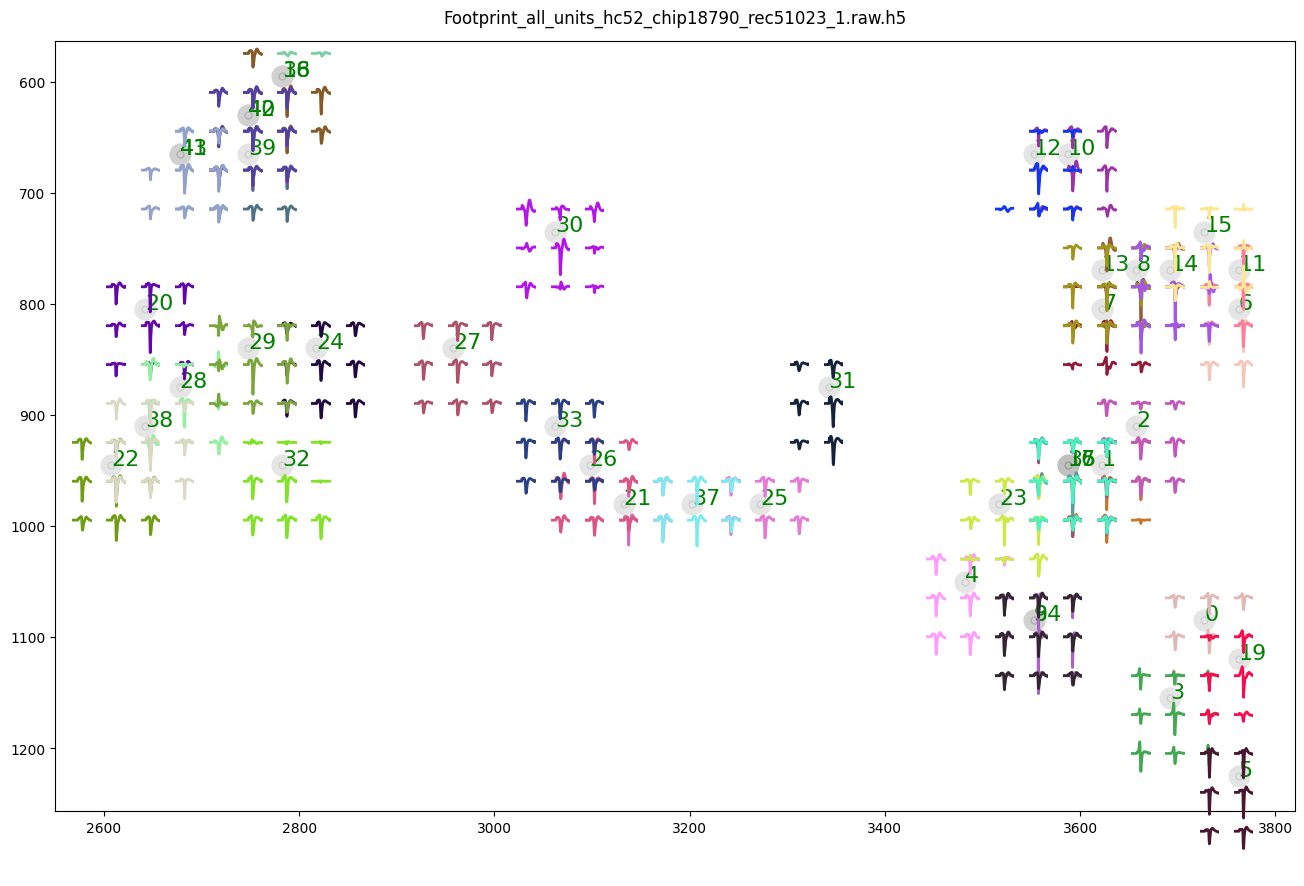

In [46]:
#  check footprint
neuron_dict = spike_data_hckcr_3.neuron_data[0]
fig, axs = plt.subplots(figsize=(16, 10), facecolor='white')
axs = plot.plot_footprint_all(axs, file_name, neuron_dict, 
                              spike_data_hckcr_3.metadata[0])
for k in neuron_dict.keys():
    pos = neuron_dict[k]['position']
    ch = neuron_dict[k]['channel']
    axs.text(pos[0], pos[1], str(str(k)), color="g", fontsize=16)


In [99]:
#  Also check power density 
from neurodsp.spectral import compute_spectrum
from neurodsp.spectral import compute_spectrum_wavelet
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.filt import filter_signal
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.plts import plot_time_series, plot_timefrequency

figure_path = "lfp_test/"
fs = 20000.0
dec = 20
fs_down = fs/dec
sections = ["no_bic", "bic", "pre", "stim"]
rec_period = [[10, 30], [30, 50], [60, 80], [80, 100]]
for i in range(spike_data_hckcr_3.N):
    # clusters = np.arange(0, spike_data_hckcr_3.N)
    channel = [spike_data_hckcr_3.neuron_data[0][i]['channel']]
    raw_trace = {"no_bic": single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, rec_period[0]),
                "bic": single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, rec_period[1]),
                "pre": single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, rec_period[2]),
                "stim": single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, rec_period[3])}
    print(i, channel,
          raw_trace["bic"].shape,
          raw_trace["pre"].shape,
          raw_trace["stim"].shape)
    psd_cor = {"no_bic":[], "bic":[], "pre": [], "stim": []}
    freqs = np.linspace(1, 50, 50)
    fig, axs = plt.subplots(1, 4, figsize=(32, 6), tight_layout=True)
    fig.suptitle("Unit" + str(i), fontsize=12)
    for j in range(len(sections)):
        raw_trace_sec = raw_trace[sections[j]]
        # wav_lfp = analysis.butter_bandpass_filter(raw_trace_sec, 0.1, 100)
        wav_lfp = filter_signal(raw_trace_sec, fs, pass_type='bandpass', 
                                filter_type="iir", butterworth_order=5, f_range=(1, 100))
    #     wav_lfp = downsample(wav_lfp, dec=dec)[1]
        lfp_cor = artifact_removal(downsample(wav_lfp, dec=dec)[1])
    #     # print(lfp_cor.shape)    

        mwt = compute_wavelet_transform(lfp_cor, fs=fs_down, n_cycles=10, freqs=freqs)
        plot_timefrequency(np.arange(0, 20, 1/fs_down), freqs, mwt, 
                           ax=axs[j], cmap='jet')
        xx,yy = np.meshgrid(np.arange(0, 20, 1/fs_down), freqs)
        ZZ = abs(mwt)
        im = axs[j].pcolor(xx,yy,ZZ, norm=LogNorm(vmin=10e-3, vmax=10e3), cmap='jet')
        plt.colorbar(im, orientation='vertical')
        axs[j].set_title(sections[j] + str(rec_period[j]))
        freq, psd = compute_spectrum(lfp_cor, fs_down, method='welch', 
                                     avg_type='mean', nperseg=fs_down*2)
        print(freq.shape, psd.shape)
        psd_cor[sections[j]] = [freq, psd]
    plt.savefig("unit_{}_neurodsp_spectrum.png".format(i), dpi=300)
    plt.close()
    plot_power_spectra(
            [psd_cor["no_bic"][0][2:200], psd_cor["bic"][0][2:200], 
             psd_cor["pre"][0][2:200], psd_cor["stim"][0][2:200]],
            [psd_cor["no_bic"][1][2:200], psd_cor["bic"][1][2:200], 
             psd_cor["pre"][1][2:200], psd_cor["stim"][1][2:200]],
            ['no_bic', 'bic', 'pre', 'stim'])
    plt.savefig("unit_{}_neurodsp_psd.png".format(i), dpi=300)
    plt.close()

0 [343] (1, 400000) (1, 400000) (1, 400000)


/home/kang/PycharmProjects/braingeneers/venv/lib/python3.10/site-packages/neurodsp/filt/filter.py:98: UserWarning: Edge artifacts are not removed when using an IIR filter.
/home/kang/PycharmProjects/braingeneers/venv/lib/python3.10/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10


(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
1 [25] (1, 400000) (1, 400000) (1, 400000)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
2 [37] (1, 400000) (1, 400000) (1, 400000)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
3 [39] (1, 400000) (1, 400000) (1, 400000)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
4 [516] (1, 400000) (1, 400000) (1, 400000)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
5 [71] (1, 400000) (1, 400000) (1, 400000)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
6 [73] (1, 400000) (1, 400000) (1, 400000)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
7 [81] (1, 400000) (1, 400000) (1, 400000)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
(1001,) (1001,)
8 [93] (1, 400000) (1, 400000) (1, 400000)
(1001,) (1001,)
(1001,) (1001,)


In [ ]:
#  Instead of filter and remove artifact by epoch indiviually, do this to the complete raw trace, then separate 
from neurodsp.spectral import compute_spectrum
from neurodsp.spectral import compute_spectrum_wavelet
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.filt import filter_signal
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.plts import plot_time_series, plot_timefrequency

figure_path = "lfp_test/"
fs = 20000.0
dec = 20
fs_down = fs/dec
# sections = ["no_bic", "bic", "pre", "stim"]
# rec_period = [[10, 30], [30, 50], [60, 80], [80, 100]]
sections = ["pre", "stim"]
rec_period = [[60, 80], [80, 100]]
for i in range(12, spike_data_hckcr_3.N):
    channel = [spike_data_hckcr_3.neuron_data[0][i]['channel']]
    raw_trace_all = single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, [rec_period[0][0], rec_period[1][1]])
    # raw_trace = {"pre": single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, rec_period[0]),
                # "stim": single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, rec_period[1])}
    print(i, channel, raw_trace_all.shape)

    wav_lfp = filter_signal(raw_trace_all, fs, pass_type='bandpass', 
                            filter_type="iir", butterworth_order=5, f_range=(1, 100))
    lfp_cor = artifact_removal(downsample(wav_lfp, dec=dec)[1])
    scaler = np.sqrt(np.mean(lfp_cor[int(fs_down*20): ]**2)) / np.sqrt(np.mean(lfp_cor[: int(fs_down*20)]**2))
    lfp_sections = {"pre": lfp_cor[: int(fs_down*20)] * scaler, 
                    "stim": lfp_cor[int(fs_down*20): ] * 1}
    
    psd_cor = {"pre": [], "stim": []}
    freqs = np.linspace(1, 50, 50)
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), tight_layout=True)
    fig.suptitle("Unit" + str(i), fontsize=12)
    for j in range(len(sections)):
        # mwt = compute_wavelet_transform(lfp_sections[sections[j]], fs=fs_down, n_cycles=10, freqs=freqs)
        # plot_timefrequency(np.arange(0, 20, 1/fs_down), freqs, mwt, 
        #                    ax=axs[j], cmap='jet')
        # xx,yy = np.meshgrid(np.arange(0, 20, 1/fs_down), freqs)
        # ZZ = abs(mwt)
        # # print(ZZ.shape, ZZ)
        # im = axs[j].pcolor(xx,yy,ZZ, norm=LogNorm(vmin=np.amin(ZZ), vmax=np.amax(ZZ)), cmap='jet')
        # plt.colorbar(im, orientation='vertical')
        # axs[j].set_title(sections[j] + str(rec_period[j]))
        freq, psd = compute_spectrum(lfp_sections[sections[j]], fs_down, method='welch', 
                                     avg_type='mean', nperseg=fs_down*2)
        print(freq.shape, psd.shape)
        psd_cor[sections[j]] = [freq, psd]
    # plt.savefig("unit_{}_neurodsp_spectrum_together_normalized_rms.png".format(i), dpi=300)
    # plt.close()
    plot_power_spectra(
            [ 
             psd_cor["pre"][0][2:200], psd_cor["stim"][0][2:200]],
            [ 
             psd_cor["pre"][1][2:200], psd_cor["stim"][1][2:200]],
            ['pre', 'stim'])
    plt.savefig(figure_path + "unit_{}_neurodsp_psd_together_normalized_rms.png".format(i), dpi=300)
    plt.close()

In [16]:
#  Instead of filter and remove artifact by epoch indiviually, do this to the complete raw trace, then plot all times 
from neurodsp.spectral import compute_spectrum
from neurodsp.spectral import compute_spectrum_wavelet
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.filt import filter_signal
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.plts import plot_time_series, plot_timefrequency

figure_path = "lfp_test/"
fs = 20000.0
dec = 20
fs_down = fs/dec
# sections = ["no_bic", "bic", "pre", "stim"]
# rec_period = [[10, 80], [80, 100]]
sections = ["pre", "stim"]
rec_period = [[60, 80], [80, 100]]
rec_length = rec_period[1][1] - rec_period[0][0]
for i in range(15, 16):
    channel = [spike_data_hckcr_3.neuron_data[0][i]['channel']]
    raw_trace_all = single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, [rec_period[0][0], rec_period[1][1]])
    # raw_trace = {"pre": single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, rec_period[0]),
                # "stim": single_unit.load_raw_maxwell(rec_hckcr_3_path, channel, rec_period[1])}
    print(i, channel, raw_trace_all.shape)

    wav_lfp = filter_signal(raw_trace_all, fs, pass_type='bandpass', 
                            filter_type="iir", butterworth_order=5, f_range=(1, 100))
    lfp_cor_org = artifact_removal(downsample(wav_lfp, dec=dec)[1])
    # normalize the amplitude because light may amplify voltage 
    scaler = np.sqrt(np.mean(lfp_cor_org[int(fs_down*rec_length/2): ]**2)) / \
             np.sqrt(np.mean(lfp_cor_org[: int(fs_down*rec_length/2)]**2))
    print("scaler: ", scaler)
    lfp_cor = np.concatenate((lfp_cor_org[: int(fs_down*rec_length/2)] * scaler,
                              lfp_cor_org[int(fs_down*rec_length/2): ] * 1))
    freqs = np.linspace(1, 100, 100)
    fig, axs = plt.subplots(1, 1, figsize=(16, 6), tight_layout=True)
    fig.suptitle("Unit" + str(i), fontsize=12)
  
    mwt = compute_wavelet_transform(lfp_cor, fs=fs_down, n_cycles=10, freqs=freqs)
    plot_timefrequency(np.arange(0, rec_length, 1/fs_down), freqs, mwt, 
                        ax=axs, cmap='jet')
    # print(mwt)
    # axs.set_yscale("log")
    # axs.set_yticks(np.linspace(0, 100, 11))
    # axs.set_ylim(0, 100)
    xx,yy = np.meshgrid(np.arange(0, rec_length, 1/fs_down), freqs)
    ZZ = abs(mwt)
    im = axs.pcolor(xx,yy,ZZ, norm=LogNorm(vmin=np.amin(ZZ), vmax=np.amax(ZZ)), cmap='jet')
    plt.colorbar(im, orientation='vertical')
 
    plt.savefig(figure_path + "unit_{}_neurodsp_spectrum_together_norm_linear_yaxis.png".format(i), dpi=300)
    plt.close()

10 [385] (1, 800000)
scaler:  1.3148569794877165
11 [413] (1, 800000)
scaler:  1.5672590333085756
12 [235] (1, 800000)
scaler:  1.186324768254461
13 [271] (1, 800000)
scaler:  1.266250519282979
14 [275] (1, 800000)


In [100]:
wav_lfp = sp.eeg.ATAR(wav_data, beta=0.1, OptMode='soft')

wav_delta = analysis.butter_bandpass_filter(wav_data, 0.5, 4)
wav_theta = analysis.butter_bandpass_filter(wav_data, 4, 8)
wav_alpha = analysis.butter_bandpass_filter(wav_data, 8, 13)
wav_beta = analysis.butter_bandpass_filter(wav_data, 13, 30)
wav_gamma = analysis.butter_bandpass_filter(wav_data, 30, 50)

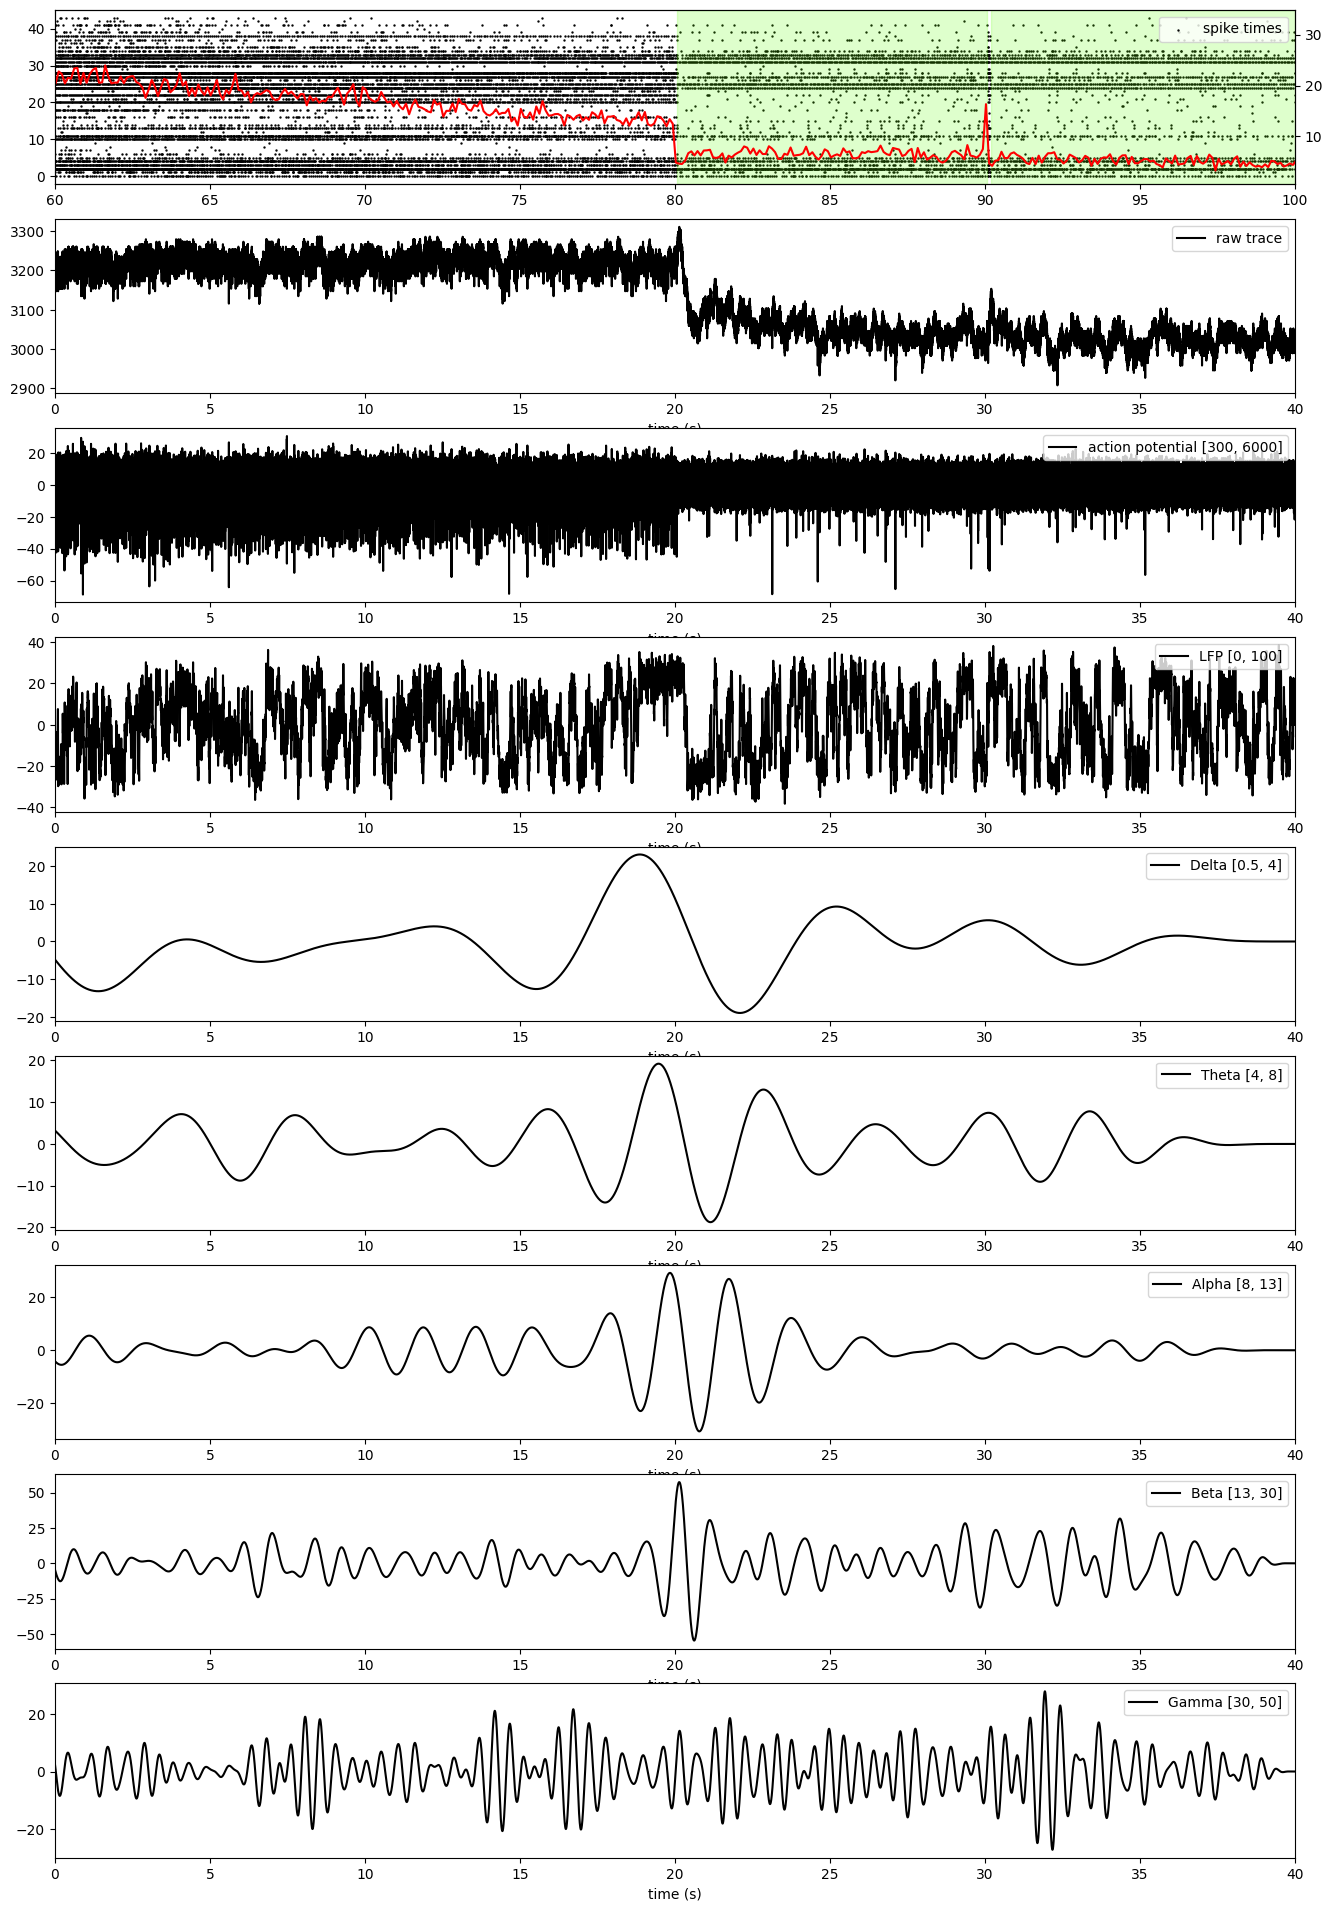

In [103]:
# plot
filtered_fs = [raw_trace, ap_trace]
filtered_down = [wav_lfp, wav_delta, wav_theta, wav_alpha, wav_beta, wav_gamma]
subbands_fs = ["raw trace", "action potential [300, 6000]"]
subbands_down = ["LFP [0, 100]", 
            "Delta [0.5, 4]", "Theta [4, 8]", "Alpha [8, 13]", 
            "Beta [13, 30]", "Gamma [30, 50]"]
fig, ax = plt.subplots(len(filtered_fs)+len(filtered_down)+1, 1, figsize=(16,  24))

# spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax[0])
# ax[0].set_xlim(0, total_duration)
# # ax[0].set_ylim(0, 0.5*sampling_frequency)
# # ax[0].set_ylim(2.0/total_duration, 0.5*sampling_frequency)
# y_min = 0.1 if min(frequencies) > 0.1 else min(frequencies)
# # ax[0].set_ylim(1, max(frequencies))
# # ax[0].set_ylim(1, 100)
# ax[0].set_xlabel('time (s)')
# ax[0].set_ylabel('frequency (Hz)')
# ax[0].set_yscale('log')

# spike_times = spike_data_hckcr_3.train[unit_id]/1000
# spike_times = np.sort(np.hstack(spike_data_hckcr_3.train))/1000
for i in range(len(spike_data_hckcr_3.train)-1):
    ax[0].scatter(spike_data_hckcr_3.train[i]/1000, 
                  [i] * len(spike_data_hckcr_3.train[i]), s=0.5, color='k')
ax[0].scatter(spike_data_hckcr_3.train[-1]/1000, 
              [spike_data_hckcr_3.N-1] * len(spike_data_hckcr_3.train[-1]), 
              s=0.5, color='k', label='spike times')
if len(stim_pairs_bi.shape) == 2:
    for pairs in stim_pairs_bi:
        ax[0].axvspan(pairs[0], pairs[1], color='#5EFF00', alpha=0.2)
bins, firing_rate = analysis.moving_fr_rate(spike_data_hckcr_3.train)  # second y axis
ax_y = ax[0].twinx()
ax_y.plot(bins[:-1]/1000, firing_rate, color='r')
ax_y.set_ylim(min(firing_rate), max(firing_rate)*1.2)
ax[0].set_xlim(rec_period)
ax[0].legend(loc="upper right")

for i in range(1, len(subbands_fs)+1):
    ax[i].plot(raw_sample_times, filtered_fs[i-1], color='k', label=str(subbands_fs[i-1]))
    ax[i].set_xlim(0, total_duration)
    ax[i].set_xlabel('time (s)')
    # ax[i].set_ylim(-np.abs(wav_data).max()*1.2,np.abs(wav_data).max()*1.2)
    ax[i].legend(loc="upper right")

for i in range(3, len(subbands_down)+3):
    ax[i].plot(sample_times, filtered_down[i-3], color='k', label=str(subbands_down[i-3]))
    ax[i].set_xlim(0, total_duration)
    ax[i].set_xlabel('time (s)')
    # ax[i].set_ylim(-np.abs(wav_data).max()*1.2,np.abs(wav_data).max()*1.2)
    ax[i].legend(loc="upper right")


